In [1]:

import numpy as np

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Conv3D, ConvLSTM2D, BatchNormalization
from keras.models import Sequential

import matplotlib.pyplot as plt
import os

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import zipfile
import os

zip_train = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/double_pendulum.zip','r')
zip_train.extractall('/tmp')
zip_train.close()


GOOD. MINIMIZE DATA AND EPOCHS FOR NOW



In [5]:
import cv2
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from skimage.util import random_noise

n_samples = 600 #run w/ less data for better results
n_frames = 30
row = 128
col = 128
dataset = np.zeros((n_samples, n_frames, row, col), dtype=float)

source_directory = "/tmp/double_pendulum"

for folder_num in range(n_samples):
    folder_path = source_directory + "/" + str(folder_num)
    if os.path.isdir(folder_path):
        for idx in range(n_frames):
            file_path = folder_path + "/" + str(idx) + ".png"
            img = cv2.imread(file_path)

            # Resize the image to 128x128
            img_resized = cv2.resize(img, (row, col))

            # Convert the image to grayscale
            img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
            # img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Apply a threshold to create a binary mask
            _, binary_mask = cv2.threshold(img_gray, 200, 255, cv2.THRESH_BINARY)

            # Invert the binary mask
            inverted_mask = cv2.bitwise_not(binary_mask)

            # Set all pixels to 0 where the mask is black
            img_processed = cv2.bitwise_and(img_resized, img_resized, mask=inverted_mask)

            # Convert the processed image to grayscale
            img_normalized = cv2.cvtColor(img_processed, cv2.COLOR_BGR2GRAY)
            img_normalized = img_normalized / 255.0

            # Add salt and pepper noise
            img_noisy = random_noise(img_normalized, mode='s&p', amount=0.05)

            # Normalize the pixel values to the range [0, 1]
            # img_noisy = img_noisy / 255.0

            # Assign the processed image to the dataset
            dataset[folder_num][idx] = img_noisy

In [6]:
dataset = dataset[..., np.newaxis]
dataset.shape

(600, 30, 128, 128, 1)

In [7]:
X = dataset[:, 0:n_frames-1, :, :]
y = dataset[:, 1:n_frames, :, :]


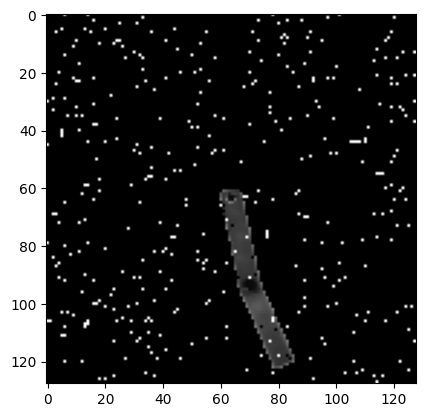

In [8]:
# Show example image
plt.imshow(dataset[79][0], cmap='gray')
plt.show()

In [9]:
from keras.layers import Attention, GlobalAveragePooling3D, concatenate, Reshape, Flatten

seq = Sequential()

seq.add(ConvLSTM2D(filters=128, kernel_size=(3, 3),
                   input_shape=(None, 128, 128, 1),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=64, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=64, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=64, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

# seq.add(Conv3D(filters=1, kernel_size=(3, 3, 3),
#                activation='sigmoid',
#                padding='same', data_format='channels_last'))
# seq.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
# Add Attention Layer
attention = Attention()
conv_lstm_output = seq.get_layer(index=-2).output
attention_result = attention([conv_lstm_output, conv_lstm_output])

# Add Global Average Pooling
pooled_attention = GlobalAveragePooling3D()(attention_result)
# Flatten the conv_lstm_output
flattened_conv_lstm = Flatten()(conv_lstm_output)

# Reshape the attention output
reshaped_attention = Reshape((1, 1, 64))(pooled_attention)

# Flatten the reshaped_attention
flattened_attention = Flatten()(reshaped_attention)

# Concatenate the flattened original output and the flattened reshaped attention
combined = concatenate([flattened_conv_lstm, flattened_attention])

# Continue with the final Conv3D layer
seq.add(Conv3D(filters=1, kernel_size=(3, 3, 3), activation='sigmoid', padding='same', data_format='channels_last'))
seq.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])


Epoch 1/15
1/1 [==============================] - 0s 425ms/step


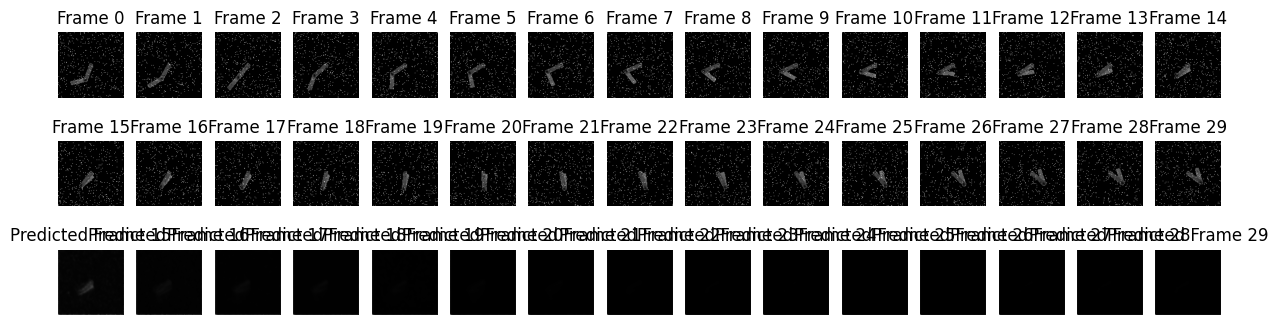

180/180 [==============================] - 356s 2s/step - loss: 0.0475 - accuracy: 0.9662 - val_loss: 0.1997 - val_accuracy: 0.9502 - lr: 0.0010
Epoch 2/15
1/1 [==============================] - 0s 423ms/step


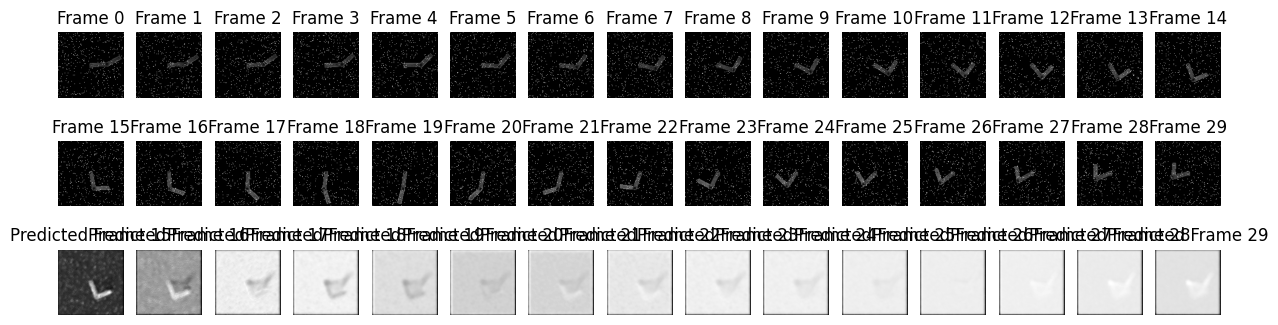

180/180 [==============================] - 368s 2s/step - loss: 0.0223 - accuracy: 0.9721 - val_loss: 0.0238 - val_accuracy: 0.9725 - lr: 0.0010
Epoch 3/15
1/1 [==============================] - 0s 412ms/step


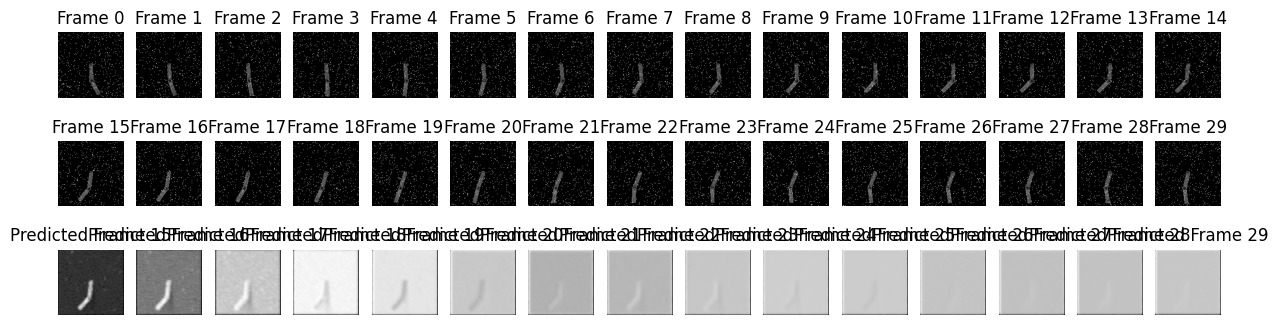

180/180 [==============================] - 368s 2s/step - loss: 0.0219 - accuracy: 0.9722 - val_loss: 0.0225 - val_accuracy: 0.9725 - lr: 0.0010
Epoch 4/15
1/1 [==============================] - 0s 410ms/step


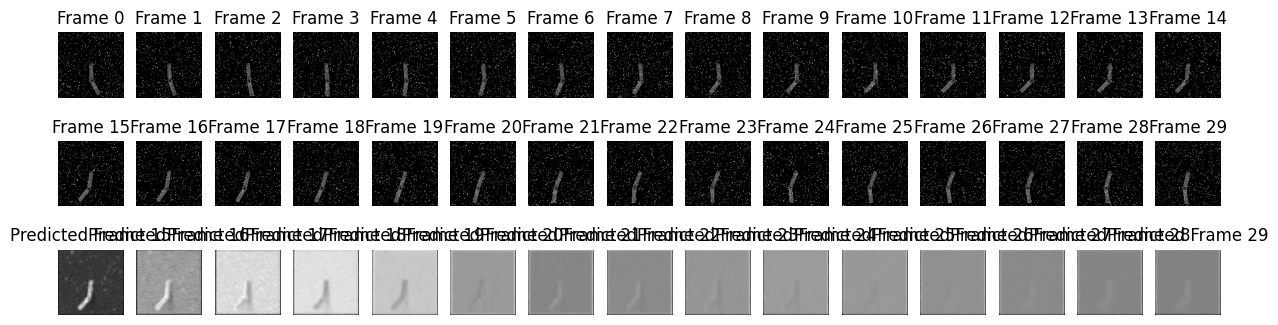

180/180 [==============================] - 368s 2s/step - loss: 0.0216 - accuracy: 0.9722 - val_loss: 0.0227 - val_accuracy: 0.9726 - lr: 0.0010
Epoch 5/15
1/1 [==============================] - 0s 411ms/step


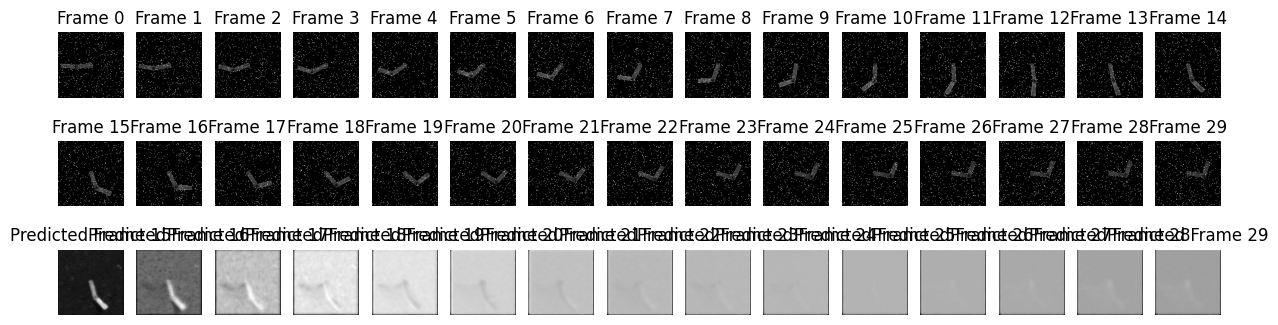

180/180 [==============================] - 368s 2s/step - loss: 0.0215 - accuracy: 0.9722 - val_loss: 0.0214 - val_accuracy: 0.9726 - lr: 0.0010
Epoch 6/15
1/1 [==============================] - 0s 413ms/step


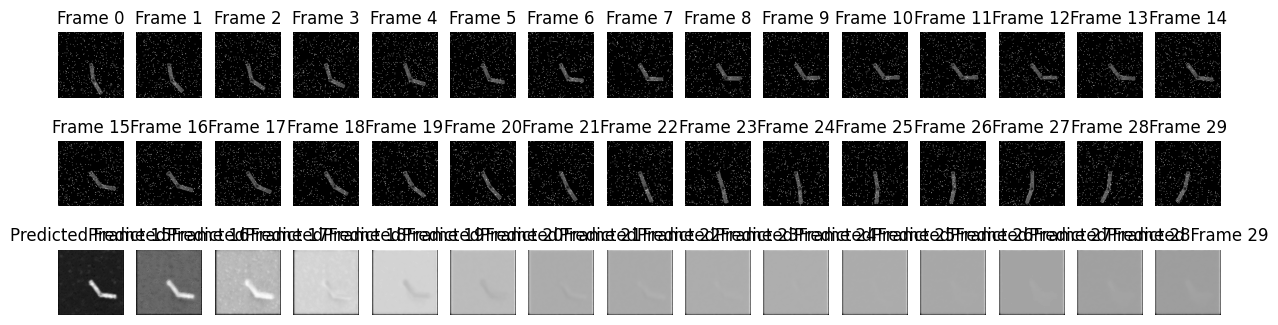

180/180 [==============================] - 353s 2s/step - loss: 0.0215 - accuracy: 0.9722 - val_loss: 0.0217 - val_accuracy: 0.9726 - lr: 0.0010
Epoch 7/15
1/1 [==============================] - 0s 411ms/step


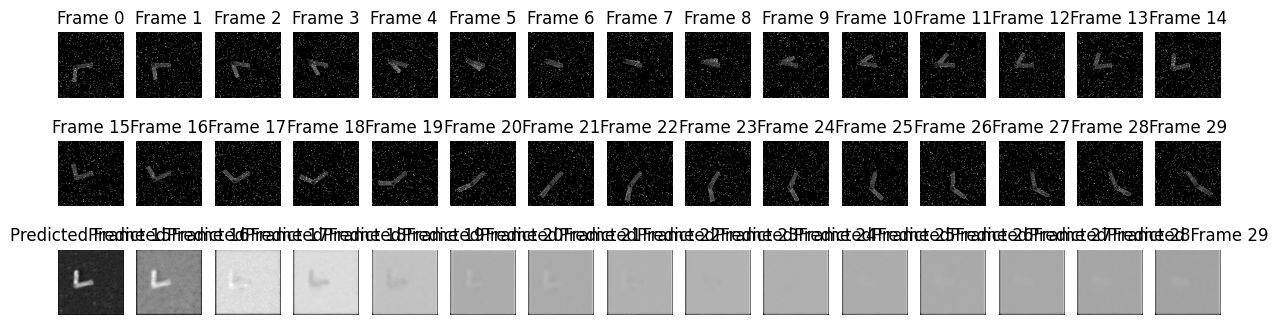

180/180 [==============================] - 367s 2s/step - loss: 0.0214 - accuracy: 0.9722 - val_loss: 0.0229 - val_accuracy: 0.9726 - lr: 0.0010
Epoch 8/15
1/1 [==============================] - 0s 420ms/step


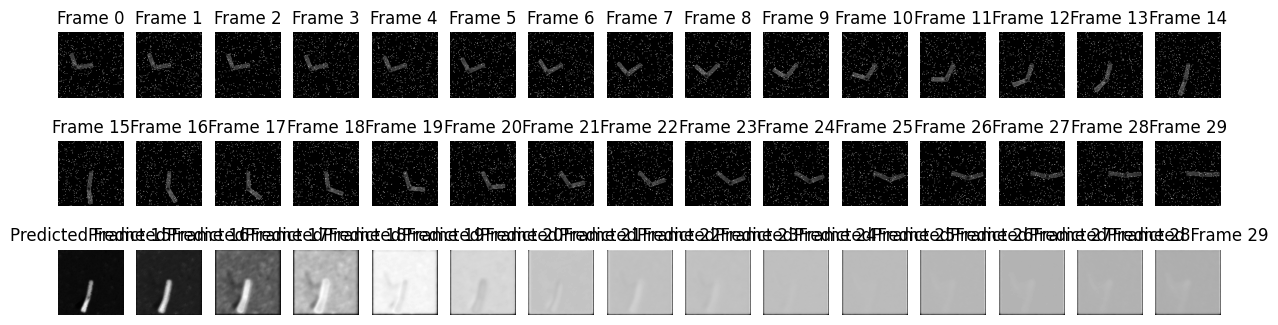

180/180 [==============================] - 368s 2s/step - loss: 0.0214 - accuracy: 0.9722 - val_loss: 0.0212 - val_accuracy: 0.9726 - lr: 0.0010
Epoch 9/15
1/1 [==============================] - 0s 414ms/step


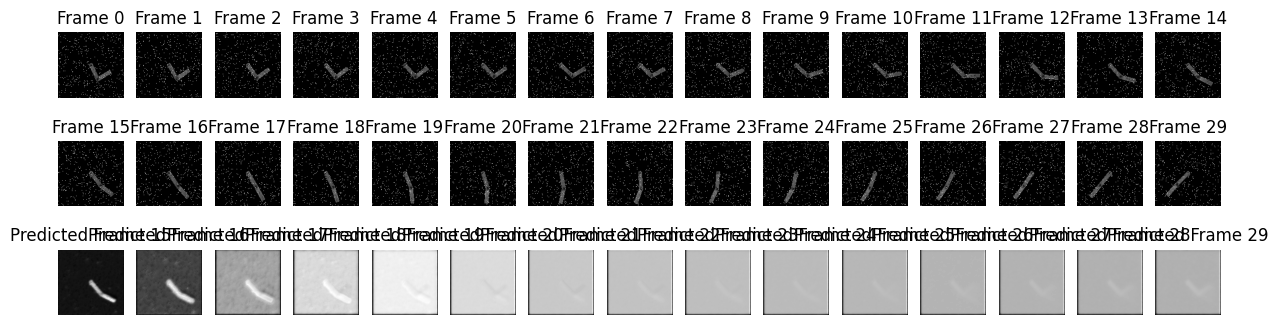

180/180 [==============================] - 368s 2s/step - loss: 0.0213 - accuracy: 0.9722 - val_loss: 0.0220 - val_accuracy: 0.9726 - lr: 0.0010
Epoch 10/15
1/1 [==============================] - 0s 417ms/step


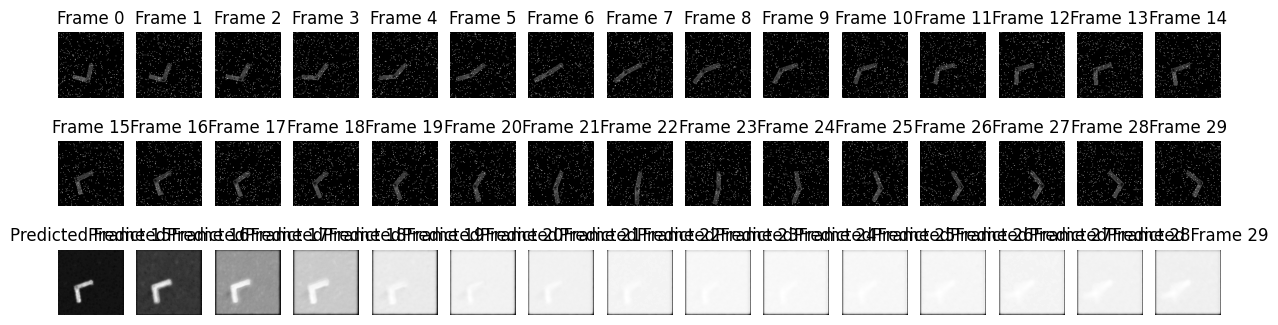

180/180 [==============================] - 367s 2s/step - loss: 0.0213 - accuracy: 0.9722 - val_loss: 0.0213 - val_accuracy: 0.9726 - lr: 0.0010
Epoch 11/15
1/1 [==============================] - 0s 411ms/step


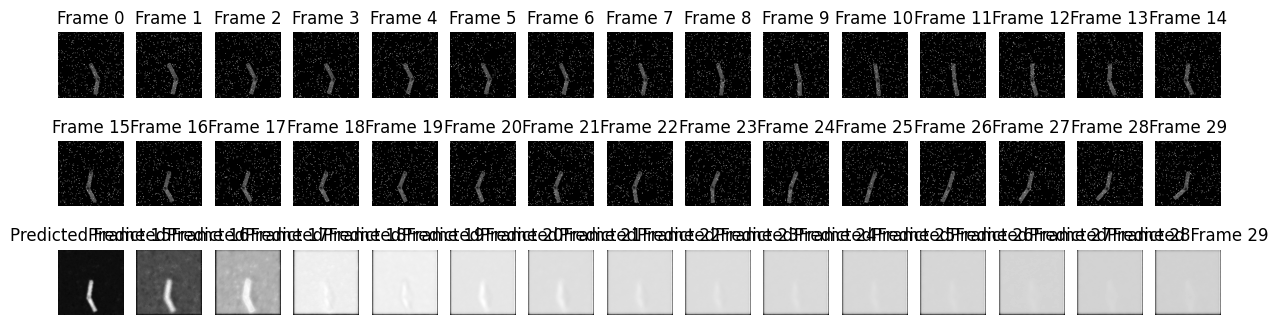

180/180 [==============================] - 368s 2s/step - loss: 0.0212 - accuracy: 0.9722 - val_loss: 0.0211 - val_accuracy: 0.9726 - lr: 0.0010
Epoch 12/15
1/1 [==============================] - 0s 415ms/step


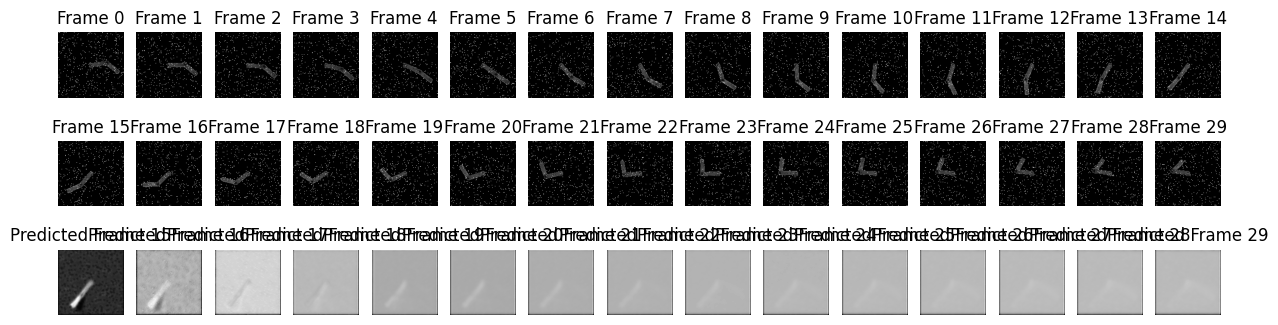

180/180 [==============================] - 367s 2s/step - loss: 0.0212 - accuracy: 0.9722 - val_loss: 0.0241 - val_accuracy: 0.9726 - lr: 0.0010
Epoch 13/15
1/1 [==============================] - 0s 414ms/step


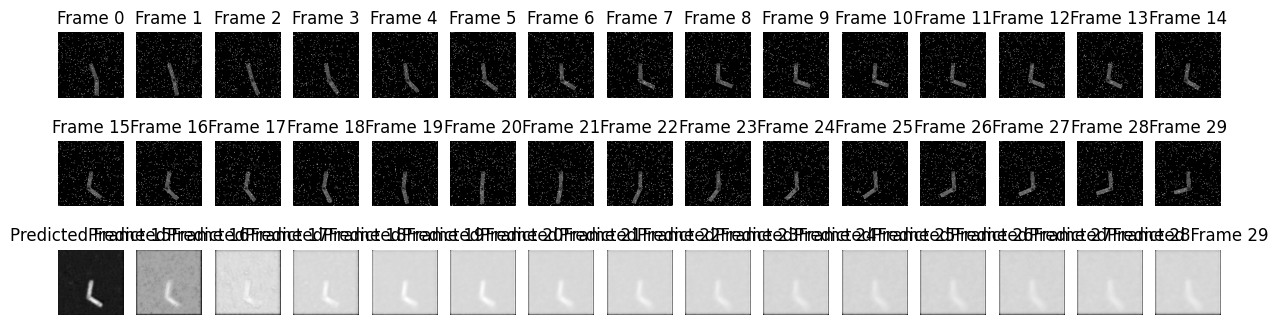

180/180 [==============================] - 354s 2s/step - loss: 0.0212 - accuracy: 0.9722 - val_loss: 0.0212 - val_accuracy: 0.9726 - lr: 0.0010
Epoch 14/15
1/1 [==============================] - 0s 415ms/step


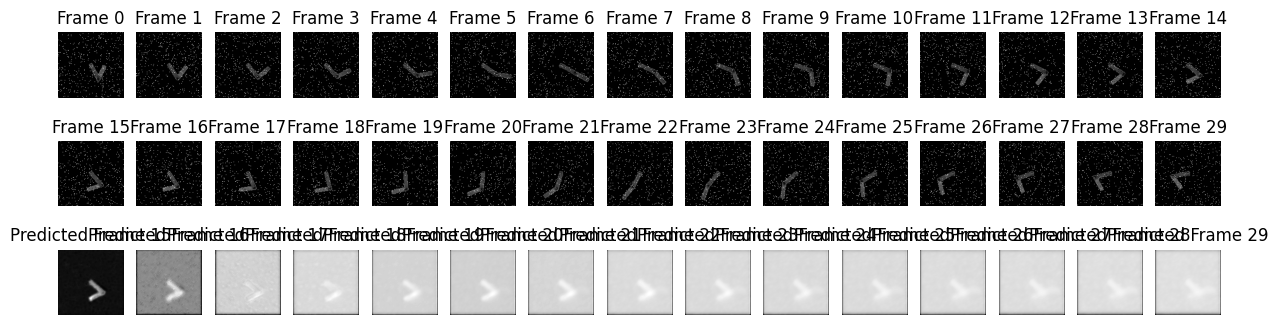

180/180 [==============================] - 354s 2s/step - loss: 0.0212 - accuracy: 0.9722 - val_loss: 0.0211 - val_accuracy: 0.9726 - lr: 0.0010
Epoch 15/15
1/1 [==============================] - 0s 412ms/step


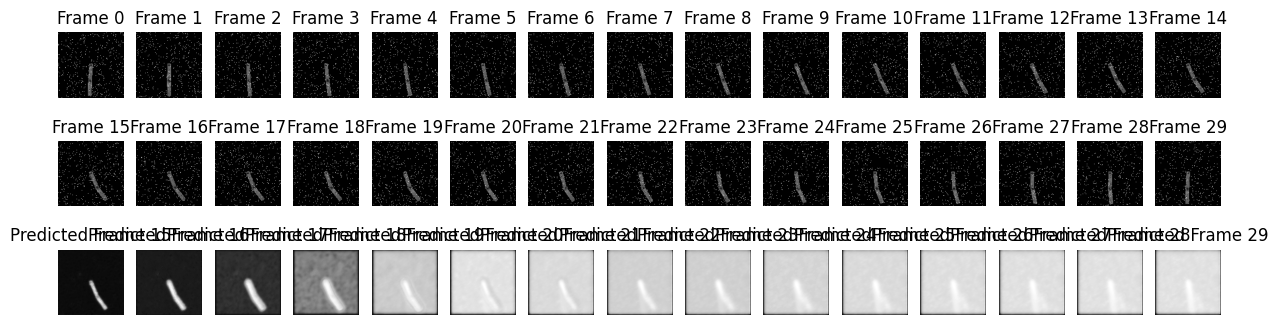

180/180 [==============================] - 368s 2s/step - loss: 0.0212 - accuracy: 0.9722 - val_loss: 0.0214 - val_accuracy: 0.9726 - lr: 0.0010


In [11]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback

half_imgs = int(30/2)

early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 15
batch_size = 1

class PrintPredictionCallback(Callback):
    def __init__(self, dataset, half_imgs):
        super(PrintPredictionCallback, self).__init__()
        self.dataset = dataset
        self.half_imgs = half_imgs

    def on_epoch_end(self, epoch, logs=None):
        # Select a random example from the validation dataset.
        example = self.dataset[random.randrange(301, 399)]

        # Pick the first/last ten frames from the example.
        frames = example[:self.half_imgs, ...]  # First 15
        original_frames = example[self.half_imgs:, ...]  # Last 15
        ogog_frames = example[:self.half_imgs, ...]  # First 15, unadulterated

        # Predict a new set of 10 frames.
        for _ in range(self.half_imgs):
            # Extract the model's prediction and post-process it.
            new_prediction = self.model.predict(np.expand_dims(frames, axis=0))
            new_prediction = np.squeeze(new_prediction, axis=0)
            predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

            # Extend the set of prediction frames.
            frames = np.concatenate((frames, predicted_frame), axis=0)

        # Construct a figure for the original and new frames.
        fig, axes = plt.subplots(3, self.half_imgs, figsize=(self.half_imgs, 4))

        for idx, ax in enumerate(axes[0]):
            ax.imshow(ogog_frames[idx], cmap='gray')
            ax.set_title(f"Frame {idx}")
            ax.axis("off")

        for idx, ax in enumerate(axes[1]):
            ax.imshow(original_frames[idx], cmap='gray')
            ax.set_title(f"Frame {idx + self.half_imgs}")
            ax.axis("off")

        # Plot the new frames.
        new_frames = frames[self.half_imgs:, ...]
        for idx, ax in enumerate(axes[2]):
            ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
            ax.set_title(f"Predicted Frame {idx + self.half_imgs}")
            ax.axis("off")

        # Display the figure.
        plt.show()

# Create an instance of the custom callback
print_prediction_callback = PrintPredictionCallback(dataset, half_imgs)

# Use the callback during model training
seq.fit(X[:200], y[:200], batch_size=1,
        epochs=epochs, validation_split=0.1, callbacks=[early_stopping, reduce_lr, print_prediction_callback])


In [16]:
import random
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import LinearSegmentedColormap

# cmap = LinearSegmentedColormap.from_list("custom_colormap", ["black", "gray", "white"])

# Create a PDF file to save the figures
with PdfPages('/output_frames_vrun.pdf') as pdf:
    # for 300 training
    for i in range(30):
        # Select a random example from the validation dataset.
        example = dataset[random.randrange(550, 599)]

        # Pick the first/last ten frames from the example.
        frames = example[:15, ...]  # first 15
        original_frames = example[15:, ...]  # last 15
        ogog_frames = example[:15, ...]  # first 15, unadulterated

        # Predict a new set of 10 frames.
        for _ in range(15):
            # Extract the model's prediction and post-process it.
            new_prediction = seq.predict(np.expand_dims(frames, axis=0))
            new_prediction = np.squeeze(new_prediction, axis=0)
            predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

            # Extend the set of prediction frames.
            frames = np.concatenate((frames, predicted_frame), axis=0)

        # Construct a figure for the original and new frames.
        fig, axes = plt.subplots(3, 15, figsize=(30, 4))

        for idx, ax in enumerate(axes[0]):
            ax.imshow(ogog_frames[idx], cmap='gray')
            ax.set_title(f"O Frame {idx}")
            ax.axis("off")
        # Plot the original frames.
        for idx, ax in enumerate(axes[1]):
            ax.imshow(original_frames[idx], cmap='gray')
            ax.set_title(f"O Frame {idx + 15}")
            ax.axis("off")

        # Plot the new frames.
        new_frames = frames[5:, ...]
        for idx, ax in enumerate(axes[2]):
            ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
            ax.set_title(f"P Frame {idx + 15}")
            ax.axis("off")

        # Display the figure.
        pdf.savefig()
        plt.close()

1/1 [==============================] - 0s 415ms/step


In [14]:
import random
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np

# Create a PDF file to save the images
pdf_filename = "/output_frames_leela_v14.pdf"
pdf_pages = PdfPages(pdf_filename)

# for 300 training
for i in range(30):
    # Select a random example from the validation dataset.
    example = dataset[random.randrange(550, 599)]

    # Pick the first/last 5 frames from the example.
    frames = example[:5, ...]
    original_frames = example[5:, ...]

    # Predict a new set of 10 frames.
    for _ in range(5):
        # Extract the model's prediction and post-process it.
        new_prediction = seq.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        # Extend the set of prediction frames.
        frames = np.concatenate((frames, predicted_frame), axis=0)

    # Construct a figure for the original and new frames.
    fig, axes = plt.subplots(2, 5, figsize=(20, 4))

    # Plot the original frames.
    for idx, ax in enumerate(axes[0]):
        ax.imshow(original_frames[idx], cmap='gray')
        ax.set_title(f"Frame {idx + 5}")
        ax.axis("off")

    # Plot the new frames.
    new_frames = frames[5:, ...]
    for idx, ax in enumerate(axes[1]):
        ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
        ax.set_title(f"Frame {idx + 5}")
        ax.axis("off")

    # Save the figure to the PDF file
    pdf_pages.savefig(fig)
    plt.close()

# Close the PDF file
pdf_pages.close()
print(f"PDF saved to {pdf_filename}")

1/1 [==============================] - 0s 113ms/step
PDF saved to /output_frames_leela_v14.pdf


In [17]:
seq.save('/model_leela_vrun.keras')